In [2]:
# Import necessary Python packages 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.colors as clr
import pandas as pd
import os
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#need to import fiona and shape
import fiona
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape

import os
import netCDF4 as nc
import matplotlib as mpl

from scipy.ndimage import binary_dilation

from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal
import cv2

2024-02-20 11:42:42.249180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
common_years = np.arange(2005,2017,1)
directory_interpolated = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_tif_interpolated/'

selecao_path = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/selecao.txt' #CHANGE IN CLUSTER
ids_selecao = np.loadtxt(selecao_path, dtype=int)

In [4]:
#get information from the shp file, without creating the output tif files

shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
boundaries = []

shapefile=fiona.open(shapefile_path)

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue

    bounds=shape(geometry).bounds

    #I expand the boundaries of 5000 m (10 pixels)
    xmin=bounds[0]-5000;ymin=bounds[1]-5000;xmax=bounds[2]+5000;ymax=bounds[3]+5000

    #Condition for Twaithes
    if id == 56:
        xmin=bounds[0]-57000;ymin=bounds[1]-50000;xmax=bounds[2]+50000;ymax=bounds[3]+10000

    #Taking the info
    ids.append(id)
    Names.append(name)
    boundaries.append([xmin,xmax,ymin,ymax])

#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'boundaries': boundaries}, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)
#Select just selecao
df = df[np.isin(df.index, ids_selecao)]

Loading all the stuff

In [4]:
#Load the thickness_tif_interpolated
thickness_interpolated = np.load(directory_interpolated + 'thickness_tif_interpolated.npy', allow_pickle=True)
thickness_interpolated = pd.DataFrame(thickness_interpolated, index = df.index, columns = common_years)

thickness_inteprolated_pixels = np.load(directory_interpolated+'/interpolated_pixels_thickness.npy', allow_pickle=True)
thickness_inteprolated_pixels = pd.DataFrame(thickness_inteprolated_pixels, index = df.index, columns = common_years)

#load the sea ice concentration
sic = np.load(directory_interpolated+'/interpolated_values_sea_ice_concnetration.npy', allow_pickle=True)
sic = pd.DataFrame(sic, index = df.index, columns = common_years)

#Load interpolated pixels
sic_interpolated_pixel = np.load(directory_interpolated+'/interpolated_pixel_sea_ice_concnetration.npy', allow_pickle=True)
sic_interpolated_pixel = pd.DataFrame(sic_interpolated_pixel, index = df.index, columns = common_years)

#Load the velocity
velocity_x = np.load(directory_interpolated+'/interpolated_velocity_inpaint_x_multi_year_sea_set_to_0.npy', allow_pickle=True)
velocity_x = pd.DataFrame(velocity_x, index = df.index, columns = common_years)

velocity_y = np.load(directory_interpolated+'/interpolated_velocity_inpaint_y_multi_year_sea_set_to_0.npy', allow_pickle=True)
velocity_y = pd.DataFrame(velocity_y, index = df.index, columns = common_years)

#load the interpolated pixels
velocity_x_interpolated_pixel = np.load(directory_interpolated+'/interpolated_pixels_inpaint_x_multi_year.npy', allow_pickle=True)
velocity_x_interpolated_pixel = pd.DataFrame(velocity_x_interpolated_pixel, index = df.index, columns = common_years)

velocity_y_interpolated_pixel = np.load(directory_interpolated+'/interpolated_pixels_inpaint_y_multi_year.npy', allow_pickle=True)
velocity_y_interpolated_pixel = pd.DataFrame(velocity_y_interpolated_pixel, index = df.index, columns = common_years)

#Load the Basal melting
bm = np.load(directory_interpolated+'/bm_interpolated_cubic_with_zero.npy', allow_pickle=True)
bm = pd.DataFrame(bm, index = df.index, columns = common_years)

#Load the ice mask
ice_mask = np.load(directory_interpolated+'/ice_mask.npy', allow_pickle=True)
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)


#NB: THE ID 47 FOR SIC DOES NOT WORK!

Interpolate again some points for thickness

In [5]:
for id in df.index:
    print(id, 'The dimensions are ', bm.loc[id,2005].shape)

2 The dimensions are  (41, 55)
3 The dimensions are  (29, 29)
4 The dimensions are  (39, 38)
6 The dimensions are  (484, 1028)
7 The dimensions are  (99, 120)
8 The dimensions are  (646, 610)
10 The dimensions are  (130, 83)
12 The dimensions are  (97, 101)
15 The dimensions are  (62, 68)
16 The dimensions are  (99, 144)
17 The dimensions are  (94, 63)
18 The dimensions are  (47, 34)
19 The dimensions are  (43, 66)
24 The dimensions are  (241, 141)
26 The dimensions are  (79, 58)
29 The dimensions are  (46, 60)
30 The dimensions are  (43, 55)
31 The dimensions are  (139, 107)
32 The dimensions are  (40, 49)
33 The dimensions are  (65, 91)
34 The dimensions are  (1544, 1817)
35 The dimensions are  (1425, 751)
36 The dimensions are  (535, 522)
37 The dimensions are  (765, 550)
38 The dimensions are  (157, 130)
39 The dimensions are  (294, 209)
40 The dimensions are  (28, 28)
41 The dimensions are  (60, 53)
43 The dimensions are  (34, 34)
44 The dimensions are  (45, 45)
45 The dimensions 

In [5]:

thickness_to_be_interpolated = pd.DataFrame(index = df.index, columns = common_years)

sic_to_be_interpolated = pd.DataFrame(index = df.index, columns = common_years)

bm_to_be_interpolated = pd.DataFrame(index = df.index, columns = common_years)

for year in common_years:
    for id in df.index:

        if np.isnan(thickness_interpolated.loc[id, year]).any():
            thickness_to_be_interpolated.loc[id, year] = True
        else:
            thickness_to_be_interpolated.loc[id, year] = False

        if np.isnan(sic.loc[id, year]).any():
            sic_to_be_interpolated.loc[id, year] = True
        else:
            sic_to_be_interpolated.loc[id, year] = False

        if np.isnan(bm.loc[id, year]).any():
            bm_to_be_interpolated.loc[id, year] = True
        else:
            bm_to_be_interpolated.loc[id, year] = False

        

In [6]:
#interpolating thickness in the points where linear inteprolation does not work! (they are not many)
#So here i tried the method nearest (7seconds))

from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

interpolated_values = pd.DataFrame(index = df.index, columns = common_years)

for year in common_years:
    for id in df.index:
        if thickness_to_be_interpolated.loc[id,year] == True:
            
            thickness_nan_coords = np.where(np.isnan(thickness_interpolated.loc[id,year]))
            thickness_no_nan_coords = np.where(~np.isnan(thickness_interpolated.loc[id,year]))
            thickness_no_nan_values = thickness_interpolated.loc[id, year][~np.isnan(thickness_interpolated.loc[id, year])]
            interpolated_values.loc[id,year] = griddata(thickness_no_nan_coords, thickness_no_nan_values, thickness_nan_coords, method='nearest')


In [8]:
#Inserting the interpolated values in the thickness_interpolated dataset
for year in common_years:
    for id in df.index:
        if thickness_to_be_interpolated.loc[id,year] == True:
            thickness_interpolated.loc[id,year][np.isnan(thickness_interpolated.loc[id,year])] = interpolated_values.loc[id,year]

In [19]:
#removing the negative thickness values and putting 0
for year in common_years:
    for id in df.index:
        thickness_interpolated.loc[id,year][thickness_interpolated.loc[id,year]<0] = 0

In [20]:
#Resave the dataset
#np.save(directory_interpolated + 'thickness_tif_interpolated_2.npy', thickness_interpolated)

Re load the inteprolated thickness 2

In [9]:
#Load the thickness_tif_interpolated_2
thickness_interpolated = np.load(directory_interpolated + 'thickness_tif_interpolated_2.npy', allow_pickle=True)
thickness_interpolated = pd.DataFrame(thickness_interpolated, index = df.index, columns = common_years)

In [11]:
#Just to check where are the problems

# for year in common_years:
#     for id in df.index:
#         if np.isnan(thickness_interpolated.loc[id, year]).any():
#             print('thickness', id, year)
#             #make the interpolation
#         if np.isnan(sic.loc[id, year]).any():
#             print('sic', id, year)
#             #make the interpolation




**Normalizing the datasets: finding min and max for each variable**

In [12]:
# Find MAXIMUM AND MINIMUM (4s)

thickness_max = pd.DataFrame(index = df.index, columns = common_years)
thickness_min = pd.DataFrame(index = df.index, columns = common_years)

velocity_x_max = pd.DataFrame(index = df.index, columns = common_years)
velocity_x_min = pd.DataFrame(index = df.index, columns = common_years)

velocity_y_max = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_min = pd.DataFrame(index = df.index, columns = common_years)

sic_max = pd.DataFrame(index = df.index, columns = common_years)
sic_min = pd.DataFrame(index = df.index, columns = common_years)

bm_max = pd.DataFrame(index = df.index, columns = common_years)
bm_min = pd.DataFrame(index = df.index, columns = common_years)

for year in common_years:
    for id in df.index:

        thickness_max.loc[id,year] = thickness_interpolated.loc[id,year].max()
        thickness_min.loc[id,year] = thickness_interpolated.loc[id,year].min()

        velocity_x_max.loc[id,year] = np.abs(velocity_x.loc[id,year]).max()
        velocity_x_min.loc[id,year] = np.abs(velocity_x.loc[id,year]).min() #careful with the sign, it should never be used and put 0 as defoults

        velocity_y_max.loc[id,year] = np.abs(velocity_y.loc[id,year]).max()
        velocity_y_min.loc[id,year] = np.abs(velocity_y.loc[id,year]).min()  #careful with the sign, it should never be used and put 0 as defoults

        bm_max.loc[id,year] = bm.loc[id,year].max()
        bm_min.loc[id,year] = bm.loc[id,year].min()


In [13]:

thickness_total_max = thickness_max.max().max()
thickness_total_min = thickness_min.min().min()

velocity_x_total_max = velocity_x_max.max().max()
velocity_y_total_max = velocity_y_max.max().max()

bm_total_max = bm_max.max().max()
bm_total_min = bm_min.min().min()

print('thickness_total_max', thickness_total_max, 'thickness_total_min', thickness_total_min)
print('velocity_x_total_max', velocity_x_total_max, 'velocity_y_total_max', velocity_y_total_max)
print('bm_total_max', bm_total_max, 'bm_total_min', bm_total_min)

thickness_total_max 3917.4866 thickness_total_min 0.0
velocity_x_total_max 7186.2764 velocity_y_total_max 7432.012
bm_total_max 142.56001 bm_total_min -276.62036


In [14]:
#prepare the new normalised datasets

thickness_normalised = pd.DataFrame(index = df.index, columns = common_years)
sic_normalised = pd.DataFrame(index = df.index, columns = common_years)
velocity_x_normalised = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_normalised = pd.DataFrame(index = df.index, columns = common_years)
bm_normalised = pd.DataFrame(index = df.index, columns = common_years)


In [15]:
#normalise the datasets (6s)

for year in common_years:
    for id in df.index:
        thickness_normalised.loc[id,year] = thickness_interpolated.loc[id,year]/thickness_total_max
        sic_normalised.loc[id,year] = sic.loc[id,year]/100
        velocity_x_normalised.loc[id,year] = velocity_x.loc[id,year]/velocity_x_total_max
        velocity_y_normalised.loc[id,year] = velocity_y.loc[id,year]/velocity_y_total_max
        bm_normalised.loc[id,year] = bm.loc[id,year]/(bm_total_max - bm_total_min)

In [6]:
#save the normalised datasets
normalised_directory = directory_interpolated + '/normalised/'

np.save(normalised_directory +  'thickness_normalised.npy', thickness_normalised)
np.save(normalised_directory +  'sic_normalised.npy', sic_normalised)
np.save(normalised_directory +  'velocity_x_normalised.npy', velocity_x_normalised)
np.save(normalised_directory +  'velocity_y_normalised.npy', velocity_y_normalised)
np.save(normalised_directory +  'bm_normalised.npy', bm_normalised)


NameError: name 'thickness_normalised' is not defined

START FROM HERE

In [7]:
#load the dataset: START FROM HERE
normalised_directory = directory_interpolated + '/normalised/'

thickness_normalised = np.load(normalised_directory +  'thickness_normalised.npy', allow_pickle=True)
thickness_normalised = pd.DataFrame(thickness_normalised, index = df.index, columns = common_years)

sic_normalised = np.load(normalised_directory +  'sic_normalised.npy', allow_pickle=True)
sic_normalised = pd.DataFrame(sic_normalised, index = df.index, columns = common_years)

velocity_x_normalised = np.load(normalised_directory +  'velocity_x_normalised.npy', allow_pickle=True)
velocity_x_normalised = pd.DataFrame(velocity_x_normalised, index = df.index, columns = common_years)

velocity_y_normalised = np.load(normalised_directory +  'velocity_y_normalised.npy', allow_pickle=True)
velocity_y_normalised = pd.DataFrame(velocity_y_normalised, index = df.index, columns = common_years)

bm_normalised = np.load(normalised_directory +  'bm_normalised.npy', allow_pickle=True)
bm_normalised = pd.DataFrame(bm_normalised, index = df.index, columns = common_years)


****Resizing**** (once we understand if it works we cn compress all the code and marge the operations of resizing and merging)

In [8]:
#create a function to resize the images

def resising_images(image, new_shape):
    new_image = cv2.resize(image, new_shape, interpolation = cv2.INTER_NEAREST)
    return new_image

In [9]:
#20s to RESCALE the images

thickness_normalised_rescaled = pd.DataFrame(index = df.index, columns = common_years)
sic_normalised_rescaled = pd.DataFrame(index = df.index, columns = common_years)
velocity_x_normalised_rescaled = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_normalised_rescaled = pd.DataFrame(index = df.index, columns = common_years)
bm_normalised_rescaled = pd.DataFrame(index = df.index, columns = common_years)
ice_mask_rescaled = pd.DataFrame(index = df.index, columns = common_years)

new_shape = (256,256)

for year in common_years:
    print(year)
    for id in df.index:
        thickness_normalised_rescaled.loc[id,year] = resising_images(thickness_normalised.loc[id,year], new_shape)
        sic_normalised_rescaled.loc[id,year] = resising_images(sic_normalised.loc[id,year], new_shape)
        velocity_x_normalised_rescaled.loc[id,year] = resising_images(velocity_x_normalised.loc[id,year], new_shape)
        velocity_y_normalised_rescaled.loc[id,year] = resising_images(velocity_y_normalised.loc[id,year], new_shape)
        bm_normalised_rescaled.loc[id,year] = resising_images(bm_normalised.loc[id,year], new_shape)
        ice_mask_rescaled.loc[id,year] = resising_images(ice_mask.loc[id,year]*1, new_shape)
        

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [10]:

#Input variables
stacked_arrays = np.stack([thickness_normalised_rescaled.values, sic_normalised_rescaled.values, velocity_x_normalised_rescaled.values, velocity_y_normalised_rescaled.values, bm_normalised_rescaled.values], axis = -1)
stacked_arrays.shape #This is 128 ice shelves, 12 years and 5 variiables. Each of those element is 256x256

#Target variables
target = np.stack([ice_mask_rescaled.values], axis = -1)

stacked_arrays = np.reshape(stacked_arrays, (128 * 12, 5))
target_mask = np.reshape(target, (128 * 12, 1))


In [11]:
#23s OLD CODE
#This creates in the shape (256,256,128*12,5) the features and (256,256,128*12,1) the target

# features = np.zeros((256,256,128*12,5))
# target = np.zeros((256,256,128*12,1))

# for i in range(128*12):

#     #Features
#     t = stacked_arrays[i,0].flatten().reshape(256,256)
#     s = stacked_arrays[i,1].flatten().reshape(256,256)
#     vx = stacked_arrays[i,2].flatten().reshape(256,256)
#     vy = stacked_arrays[i,3].flatten().reshape(256,256)
#     bm = stacked_arrays[i,4].flatten().reshape(256,256)

#     #target
#     mask = target_mask[i,0].flatten().reshape(256,256)

#     t = t[:,:,np.newaxis]
#     s = s[:,:,np.newaxis]
#     vx = vx[:,:,np.newaxis]
#     vy = vy[:,:,np.newaxis]
#     bm = bm[:,:,np.newaxis]

#     mask = mask[:,:,np.newaxis]

    

#     test = np.concatenate((t,s,vx,vy,bm), axis = -1)

#     target[:,:,i,:] = mask

#     print('The round is', i, 'and the shape is', np.shape(test))
#     features[:,:,i,:] = test


The round is 0 and the shape is (256, 256, 5)
The round is 1 and the shape is (256, 256, 5)
The round is 2 and the shape is (256, 256, 5)
The round is 3 and the shape is (256, 256, 5)
The round is 4 and the shape is (256, 256, 5)
The round is 5 and the shape is (256, 256, 5)
The round is 6 and the shape is (256, 256, 5)
The round is 7 and the shape is (256, 256, 5)
The round is 8 and the shape is (256, 256, 5)
The round is 9 and the shape is (256, 256, 5)
The round is 10 and the shape is (256, 256, 5)
The round is 11 and the shape is (256, 256, 5)
The round is 12 and the shape is (256, 256, 5)
The round is 13 and the shape is (256, 256, 5)
The round is 14 and the shape is (256, 256, 5)
The round is 15 and the shape is (256, 256, 5)
The round is 16 and the shape is (256, 256, 5)
The round is 17 and the shape is (256, 256, 5)
The round is 18 and the shape is (256, 256, 5)
The round is 19 and the shape is (256, 256, 5)
The round is 20 and the shape is (256, 256, 5)
The round is 21 and the

In [85]:
#Give shape (1536,256,256,5) to the features and (1536,256,256,1) to the target

features = np.zeros((128*12,256,256,5))
target = np.zeros((128*12,256,256,1))

for i in range(128*12):
    
        #Features
        t = stacked_arrays[i,0].flatten().reshape(256,256)
        s = stacked_arrays[i,1].flatten().reshape(256,256)
        vx = stacked_arrays[i,2].flatten().reshape(256,256)
        vy = stacked_arrays[i,3].flatten().reshape(256,256)
        bm = stacked_arrays[i,4].flatten().reshape(256,256)
    
        #target
        mask = target_mask[i,0].flatten().reshape(256,256)
    
        t = t[:,:,np.newaxis]
        s = s[:,:,np.newaxis]
        vx = vx[:,:,np.newaxis]
        vy = vy[:,:,np.newaxis]
        bm = bm[:,:,np.newaxis]
    
        mask = mask[:,:,np.newaxis]
    
        
    
        test = np.concatenate((t,s,vx,vy,bm), axis = -1)
    
        target[i,:,:,:] = mask
    
        print('The round is', i, 'and the shape is', np.shape(test))
        features[i,:,:,:] = test



The round is 0 and the shape is (256, 256, 5)
The round is 1 and the shape is (256, 256, 5)
The round is 2 and the shape is (256, 256, 5)
The round is 3 and the shape is (256, 256, 5)
The round is 4 and the shape is (256, 256, 5)
The round is 5 and the shape is (256, 256, 5)
The round is 6 and the shape is (256, 256, 5)
The round is 7 and the shape is (256, 256, 5)
The round is 8 and the shape is (256, 256, 5)
The round is 9 and the shape is (256, 256, 5)
The round is 10 and the shape is (256, 256, 5)
The round is 11 and the shape is (256, 256, 5)
The round is 12 and the shape is (256, 256, 5)
The round is 13 and the shape is (256, 256, 5)
The round is 14 and the shape is (256, 256, 5)
The round is 15 and the shape is (256, 256, 5)
The round is 16 and the shape is (256, 256, 5)
The round is 17 and the shape is (256, 256, 5)
The round is 18 and the shape is (256, 256, 5)
The round is 19 and the shape is (256, 256, 5)
The round is 20 and the shape is (256, 256, 5)
The round is 21 and the

In [86]:
features.shape

(1536, 256, 256, 5)

In [87]:
#reshape in order to be (1536,256,256,5) and (1536,256,256,1)

features = np.reshape(features, (128*12,256,256,5))

target = np.reshape(target, (128*12,256,256,1))


print(features.shape)
print(target.shape)

(1536, 256, 256, 5)
(1536, 256, 256, 1)


In [37]:
384/12

32.0

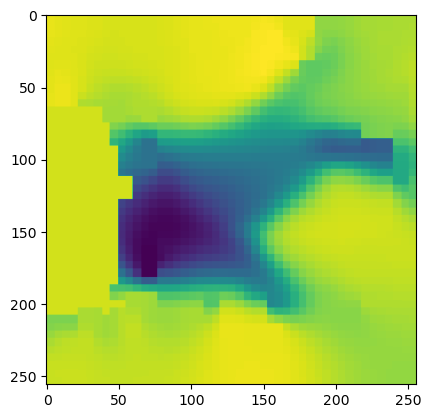

In [88]:
plt.imshow(features[384,:,:,2])

In [36]:
#check if there are nan values

for i in range(128*12):
    if np.isnan(features[i,:,:,:]).any():
        print('There are nan values in the featuresat position', i)
    if np.isnan(target[i,:,:,:]).any():
        print('There are nan values in the target at position', i)

There are nan values in the featuresat position 384
There are nan values in the featuresat position 385
There are nan values in the featuresat position 386
There are nan values in the featuresat position 387
There are nan values in the featuresat position 388
There are nan values in the featuresat position 389
There are nan values in the featuresat position 390
There are nan values in the featuresat position 391
There are nan values in the featuresat position 392
There are nan values in the featuresat position 393
There are nan values in the featuresat position 394
There are nan values in the featuresat position 395


In [89]:
#I want now remove from target and feature datasets all the features from [384,:,:,:] to [396,:,:,:] and the target from [384,:,:,:] to [395,:,:,:] (included)

features = np.delete(features, np.s_[384:396], axis = 0)
target = np.delete(target, np.s_[384:396], axis = 0)



In [90]:
print(features.shape)
print(target.shape)

(1524, 256, 256, 5)
(1524, 256, 256, 1)


In [95]:
#I would like to save the features and target datasets in order to use them in the future

np.save(normalised_directory +  'features.npy', features)
np.save(normalised_directory +  'target.npy', target)



Start from Here!

In [5]:
#Load the dataset

normalised_directory = directory_interpolated + '/normalised/'

features = np.load(normalised_directory +  'features.npy', allow_pickle=True)
target = np.load(normalised_directory +  'target.npy', allow_pickle=True)

In [6]:
#divide the dataset into training, validation and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

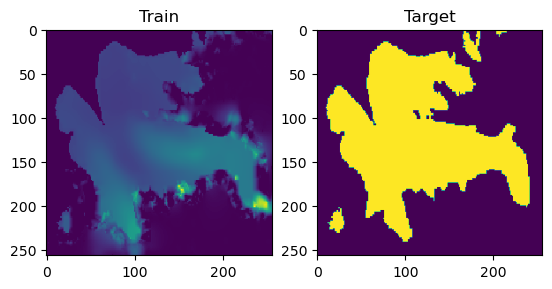

In [12]:
import matplotlib.pyplot as plt

i = 100
# Plotting the target mask
plt.subplot(1, 2, 1)
plt.imshow(X_val[i, :, :, 0])
plt.title('Train')

# Plotting the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(y_val[i, :, :, 0])
plt.title('Target')

plt.show()


In [102]:
#Now i want to convert the features and target into a tensor
features_tf = tf.convert_to_tensor(features)
target_tf = tf.convert_to_tensor(target)

Implementing the model

In [ ]:

Input_figures = (256,256,5)


In [59]:
from tensorflow import keras
from tensorflow.keras import layers

def unet_model(input_shape=(256, 256, 5)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat4 = layers.Concatenate(axis=-1)([conv2, up4])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate(axis=-1)([conv1, up5])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet_model()


In [60]:
#get model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 input_2 (InputLayer)        [(None, 256, 256, 5)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 64)         2944      ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 128)        73856     ['max_pooling2d_2[0][0]']     
          

In [61]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [62]:

model.fit(features_tf, target_tf, epochs=2, batch_size=10, validation_split=0.2, verbose=1)


Epoch 1/2
122/122 [==============================] - 2407s 20s/step - loss: 0.3683 - accuracy: 0.8346 - val_loss: 0.2009 - val_accuracy: 0.9217
Epoch 2/2
122/122 [==============================] - 2416s 20s/step - loss: 0.2193 - accuracy: 0.9130 - val_loss: 0.1562 - val_accuracy: 0.9456


In [63]:
#save the model
model.save('/Users/francesco/Desktop/unet_model.h5')

/Users/francesco/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
#save the keras model
model.save('/Users/francesco/Desktop/unet_model_keras.keras')

In [ ]:
#load the model


In [65]:
#make predictions
predictions = model.predict(features_tf, verbose=1)



48/48 [==============================] - 801s 17s/step


In [29]:
#visualise the predictions
predictions.shape

(1536, 256, 256, 1)

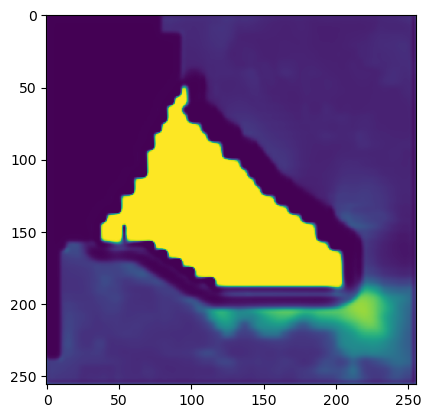

In [72]:
plt.imshow(predictions[1,:,:,0])

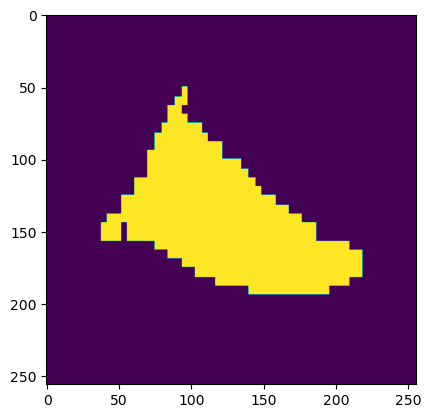

In [73]:
#Chek the predictions, if everything is nan
plt.imshow(target[1,:,:,0])

In [79]:
38*12

456

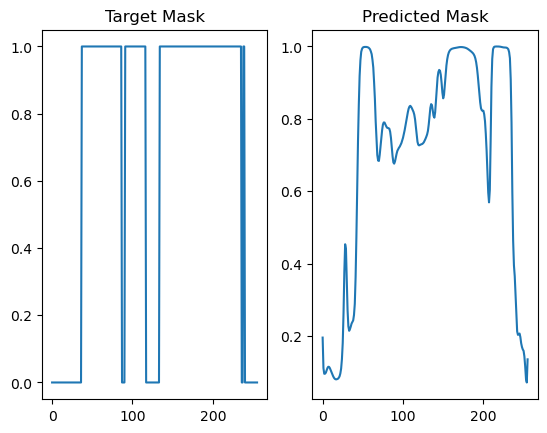

In [84]:
import matplotlib.pyplot as plt

i = 445

# Plotting the target mask
plt.subplot(1, 2, 1)
plt.plot(target[i, :, :, 0][100])
plt.title('Target Mask')

# Plotting the predicted mask
plt.subplot(1, 2, 2)
plt.plot(predictions[i, :, :, 0][100])
plt.title('Predicted Mask')

plt.show()
